### INFO 607: Project 
## Tensorflow project - Gemstone Classification


### Group
- Group member 1
    - Name: Hong Son
    - Email: hts34@drexel.edu
- Group member 2
    - Name: Brian Kong
    - Email: bk555@drexel.edu
- Group member 3
    - Name: Yiyun Zhang
    - Email: yz523@drexel.edu


### Goal
Our area of study is classifying gemstones. A gemstone is mineral, stone, or organic matter that can be cut and polished or used as jewelry or other ornament (Maula & et. al, 2017). We are fascinated by the number of different types of gemstones and the perceived value of gemstones. Some gemstones such as diamond, ruby, sapphire, and emerald carry more value than other gemstones. Thus, they are categorized into various types. The four characteristics used to categorize the type of gemstone based on physical aspects consist of the hardness, density, refraction of light, and the color of the mineral. Our research expands from a previous research done by Syarif Hidayatullah State Islamic University where they worked on image processing problems around three types of gemstone (Ruby, Sapphire, and Emerald). In this study, the researchers used the Artificial Neural Network (ANN) machine learning model and obtained relatively high accuracy for the classification problem. In our study, we will be looking at a larger sample consisting of more gemstones and evaluating the performance of a CNN model.

This project can be useful for the creation of a gemstone identification app. This app would process images to accurately classify the type of stone. Those who have a profession or a hobby for collecting rocks and identifying gemstones would find this app to be very helpful. 


In [ ]:
#from google.colab import drive
#drive.mount('/content/gdrive')

In [ ]:
# import necessary libraries and keras
import os
import cv2

import matplotlib.pyplot as plt
import seaborn as sn
import numpy as np
import tensorflow as tf

from random import randint

from keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

In [ ]:
# show available gpus
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
# create gemstone lists
gemClasses = []
gemImages = []

# create data path
dataRoot = './Dataset/archive/'
dataTrainRoot = './Dataset/archive/train/'
dataTestRoot = './Dataset/archive/test/'

In [ ]:
# read gem class names and store them
for root, dirs, files in os.walk(dataRoot):
    className = os.path.basename(root)
        
    if len(files) > 0:
        gemImages.append(len(files))
        if className not in gemClasses:
            gemClasses.append(className)
    
gems_count = len(gemClasses)
print('{} classes with {} images'.format(len(gemClasses), sum(gemImages)))

88 classes with 3228 images


In [ ]:
# read gem image and labels and store them
def getImageAndLabels(directory):
    images = []
    labels = []
    for root, dirs, files in os.walk(directory):
        className = os.path.basename(root)
        for file in files:
            try:
                image = cv2.imread(root + '/' + file)
                image = cv2.resize(image, (330, 330))
                image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
                images.append(image)
                labels.append(className)
            except Exception as e:
                break;
    images = np.array(images)
    return (images, labels)

In [ ]:
# mapping labels and classes
def getClasses(labels):
    for i, n in enumerate(labels):
        for j, k in enumerate(gemClasses):
            if n == k:
                labels[i] = j
    labels = np.array(labels)
    return labels

In [ ]:
# fill train and test lists
trainImages, trainLabels = getImageAndLabels(dataTrainRoot)
trainLabels = getClasses(trainLabels)
print('Shape of images for training: {}'.format(trainImages.shape))
print('Shape of labels for training: {}'.format(trainLabels.shape))
testImages, testLabels = getImageAndLabels(dataTestRoot)
testLabels = getClasses(testLabels)
print('Shape of images for testing: {}'.format(testImages.shape))
print('Shape of labels for testing: {}'.format(testLabels.shape))

Shape of images for training: (2856, 330, 330, 3)
Shape of labels for training: (2856,)
Shape of images for testing: (363, 330, 330, 3)
Shape of labels for testing: (363,)


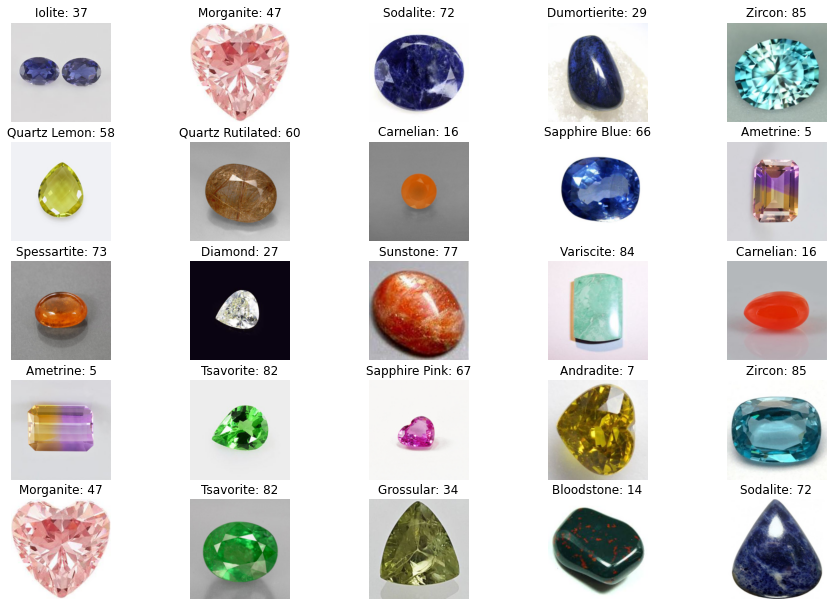

In [ ]:
# display random 5x5 gem images and their labels
x, y = plt.subplots(5, 5) 
x.subplots_adjust(0, 0, 2, 2)
for i in range(0, 5):
    for j in range(0, 5):
        randomNumber = randint(0, len(trainImages))
        randomLabel = trainLabels[randomNumber]
        y[i,j].imshow(trainImages[randomNumber])
        y[i,j].set_title(gemClasses[int(randomLabel)] + ': ' + str(randomLabel))
        y[i,j].axis('off')

In [ ]:
# define crop edge function
def cropEdge(image):
    try:
        edges = cv2.Canny(image, 220, 220)            
        
        if(np.count_nonzero(edges) > edges.size / 10000):           
            plots = np.argwhere(edges > 0)
            y1,x1 = plot.min(axis = 0)
            y2,x2 = plot.max(axis = 0)
            
            croppedImage = image[y1:y2, x1:x2]
            croppedImage = cv2.resize(croppedImage, (220, 220))
        else:
            croppedImage = cv2.resize(image, (220, 220))
    
    except Exception as e:
        croppedImage = cv2.resize(image, (220, 220))
    
    return croppedImage

In [ ]:
# show random 5 crop edge image process
def showCroppedImage(image):
    originalImage = image.copy()
    edges = cv2.Canny(image, 220, 220)
    
    if(np.count_nonzero(edges) > edges.size / 10000):
        plot = np.argwhere(edges > 0)
        y1,x1 = plot.min(axis = 0)
        y2,x2 = plot.max(axis = 0)

        croppedImage = image[y1:y2, x1:x2]  

        edgeSize = 1 #replace it with bigger size for larger images            

        originalImage[y1 - edgeSize:y1 + edgeSize, x1:x2] = [255, 0, 0]
        originalImage[y2 - edgeSize:y2 + edgeSize, x1:x2] = [255, 0, 0]
        originalImage[y1:y2, x1 - edgeSize:x1 + edgeSize] = [255, 0, 0]
        originalImage[y1:y2, x2 - edgeSize:x2 + edgeSize] = [255, 0, 0]

        croppedImage = cv2.resize(croppedImage,(220, 220))  # Convert to primary size  
        
    else:
        croppedImage = cv2.resize(image,(220, 220))
    
    fig, ax = plt.subplots(nrows = 1, ncols = 4, figsize=(10, 10))
    ax[0].imshow(image, cmap = 'gray')
    ax[0].set_title('Original', fontsize = 14)
    ax[1].imshow(edges, cmap = 'gray')
    ax[1].set_title('Edges', fontsize = 14)
    ax[2].imshow(originalImage, cmap = 'gray')
    ax[2].set_title('Box', fontsize = 14)       
    ax[3].imshow(croppedImage, cmap = 'gray')
    ax[3].set_title('Cropped', fontsize = 14) 

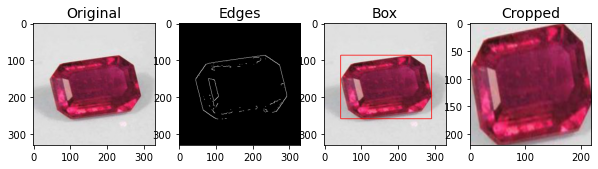

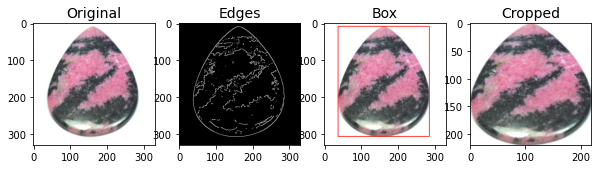

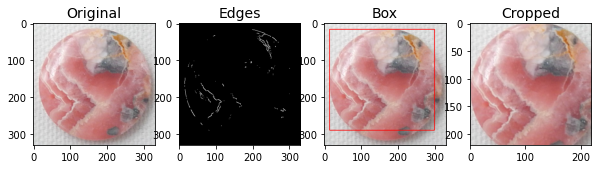

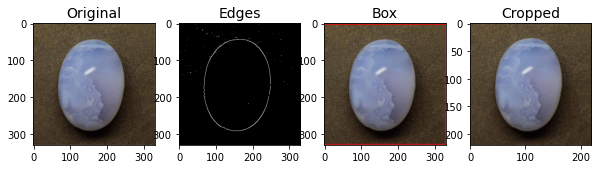

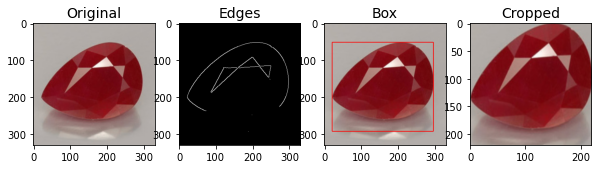

In [ ]:
# show processes
for x in range(0,5):
    showCroppedImage(trainImages[randint(0,len(trainImages))])

In [ ]:
# define crop image function
def cropImages(images):
    croppedImages = np.ndarray(shape = (len(images), 220, 220, 3), dtype = np.int)

    i = 0
    for image in images: 
        x = cropEdge(image)
        croppedImages[i] = x
        i += 1

    return croppedImages

In [ ]:
# fill processed train and test images to lists
trainImages = cropImages(trainImages)
testImages = cropImages(testImages)
print('Shape of images in train set: {} '.format(trainImages.shape))
print('Shape of images in test set: {} '.format(testImages.shape))

Shape of images in train set: (2856, 220, 220, 3) 
Shape of images in test set: (363, 220, 220, 3) 


In [ ]:
# define images and labels for train and validate
trainX = trainImages
trainY = trainLabels
validateX = testImages
validateY = testLabels
print('Shape of trainX: {}, trainY: {} '.format(trainX.shape, trainY.shape))
print('Shape of validateX: {}, validateY: {} '.format(validateX.shape, validateY.shape))

Shape of trainX: (2856, 220, 220, 3), trainY: (2856,) 
Shape of validateX: (363, 220, 220, 3), validateY: (363,) 


In [ ]:
# create model
myModel = Sequential()

myModel.add(Conv2D(32, (3, 3), activation = 'relu', padding = 'same', input_shape = (220, 220, 3)))
myModel.add(MaxPooling2D((2, 2)))

myModel.add(Conv2D(2 * 32, (3, 3), activation = 'relu', padding = 'same'))
myModel.add(MaxPooling2D((2, 2))) 

myModel.add(Conv2D(4 * 32, (3, 3), activation = 'relu', padding = 'same'))
myModel.add(MaxPooling2D((2, 2))) 

myModel.add(Conv2D(4 * 32, (3, 3), activation = 'relu', padding = 'same'))
myModel.add(AveragePooling2D(pool_size = (2, 2), strides = (2, 2))) 

myModel.add(Conv2D(4 * 32, (3, 3), activation = 'relu', padding = 'same'))
myModel.add(MaxPooling2D((2, 2))) 

myModel.add(Flatten())
myModel.add(Dropout(0.5))
myModel.add(Dense(16 * 32, activation = 'relu'))
myModel.add(Dense(87, activation = 'softmax'))
myModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 220, 220, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 110, 110, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 110, 110, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 55, 55, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 55, 55, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 27, 27, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 128)       1

In [ ]:
# define model
myModel.compile(
    optimizer = 'adam',
    loss = 'sparse_categorical_crossentropy',
    metrics = ['accuracy']
)

In [ ]:
# generate images
trainImageDataGenerate = ImageDataGenerator(
        rotation_range = 25,
        zoom_range = 0.1,
        width_shift_range = 0.1,
        height_shift_range = 0.1,
        shear_range = 0.2,
        horizontal_flip = True
)

validateImageDataGenerate = ImageDataGenerator()  

In [ ]:
# generate images for train and validate
trainGenerate = trainImageDataGenerate.flow(trainX, trainY, batch_size = 32)
validateGenerate = validateImageDataGenerate.flow(validateX, validateY, batch_size = 32)

In [ ]:
# fit model
myModel.fit(
       trainGenerate,
       steps_per_epoch = len(trainX) // 32,
       epochs = 15, 
       validation_data = validateGenerate,
       validation_steps = len(validateX) // 32,
       verbose = 1
)

Epoch 1/15
89/89 [==============================] - 36s 231ms/step - loss: 7.3249 - accuracy: 0.0146 - val_loss: 3.6620 - val_accuracy: 0.0881
Epoch 2/15
89/89 [==============================] - 20s 224ms/step - loss: 3.5278 - accuracy: 0.1164 - val_loss: 2.6355 - val_accuracy: 0.2301
Epoch 3/15
89/89 [==============================] - 20s 224ms/step - loss: 2.7312 - accuracy: 0.2298 - val_loss: 2.3365 - val_accuracy: 0.3239
Epoch 4/15
89/89 [==============================] - 20s 224ms/step - loss: 2.4201 - accuracy: 0.3096 - val_loss: 2.4597 - val_accuracy: 0.3097
Epoch 5/15
89/89 [==============================] - 20s 224ms/step - loss: 2.2379 - accuracy: 0.3280 - val_loss: 2.3424 - val_accuracy: 0.3295
Epoch 6/15
89/89 [==============================] - 20s 224ms/step - loss: 2.1572 - accuracy: 0.3683 - val_loss: 1.8840 - val_accuracy: 0.4062
Epoch 7/15
89/89 [==============================] - 20s 224ms/step - loss: 1.8725 - accuracy: 0.4252 - val_loss: 1.7929 - val_accuracy: 0.4460

In [ ]:
# model evaluation - accuracy score
score = myModel.evaluate(validateGenerate, steps = len(validateGenerate))

for i, metric in enumerate(myModel.metrics_names):
    print('{}:{}'.format(metric, score[i]))

12/12 [==============================] - 0s 24ms/step - loss: 1.4477 - accuracy: 0.5207
loss:1.447736382484436
accuracy:0.5206611752510071


F1 measure: 0.4969


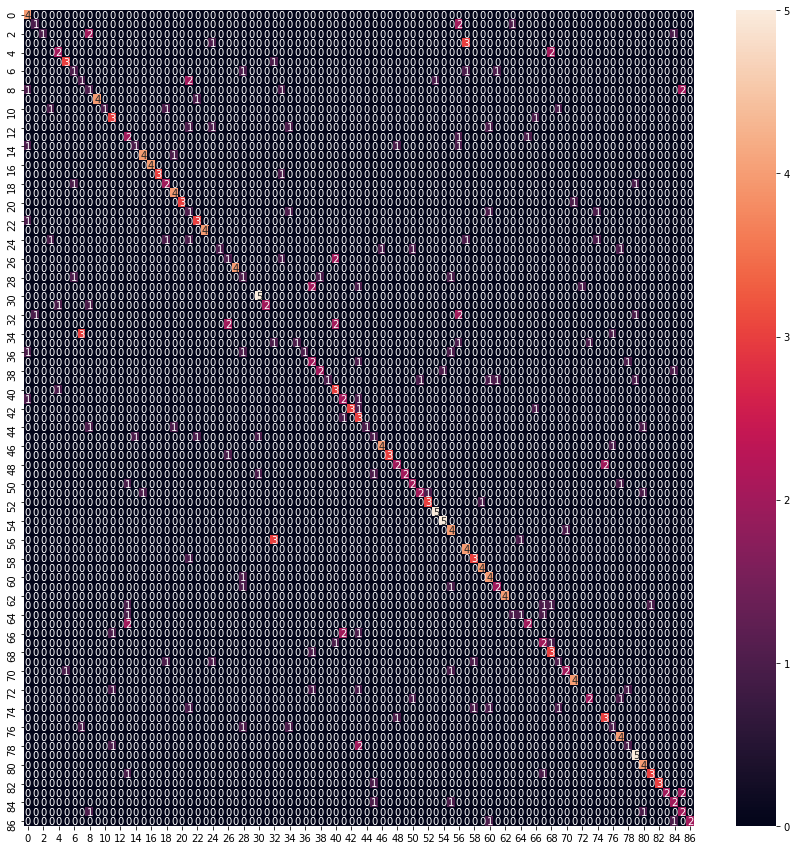

In [ ]:
# F1 measure and confusion matrix
predictY = myModel.predict(validateX)
predictY = np.argmax(predictY, axis = 1)

confusionMatrix = confusion_matrix(validateY, predictY)
f1 = f1_score(predictY, validateY, average = 'macro')

plt.figure(figsize = (15, 15))
sn.heatmap(confusionMatrix, annot = True)
print("F1 measure: {:.4f}".format(f1))